### Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### EDA

In [ ]:
df = pd.read_csv('./data/dataset.csv')

In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (350, 7)


In [5]:
print("First few rows:")
print(df.head(10))

First few rows:
   x  y  tx_04  tx_74  tx_03  tx_76  partition
0  2  2    -74    -51    -55    -69          1
1  2  2    -77    -60    -55    -70          1
2  2  2    -81    -51    -56    -55          1
3  2  2    -72    -43    -54    -60          1
4  2  2    -70    -59    -55    -60          1
5  2  2    -65    -58    -55    -68          1
6  2  2    -75    -53    -53    -69          1
7  2  2    -71    -58    -56    -69          1
8  2  2    -69    -58    -49    -70          1
9  2  2    -69    -59    -49    -72          1


In [6]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   x          350 non-null    int64
 1   y          350 non-null    int64
 2   tx_04      350 non-null    int64
 3   tx_74      350 non-null    int64
 4   tx_03      350 non-null    int64
 5   tx_76      350 non-null    int64
 6   partition  350 non-null    int64
dtypes: int64(7)
memory usage: 19.3 KB
None


In [7]:
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
                x           y       tx_04       tx_74       tx_03       tx_76  \
count  350.000000  350.000000  350.000000  350.000000  350.000000  350.000000   
mean     7.057143   10.571429  -66.442857  -61.208571  -65.540000  -68.917143   
std      3.637932    6.776352    8.739850    8.409603    7.159449    8.315518   
min      2.000000    2.000000  -86.000000  -86.000000  -86.000000 -102.000000   
25%      4.000000    5.000000  -72.000000  -66.000000  -70.750000  -75.000000   
50%      7.000000    8.000000  -67.000000  -60.500000  -66.000000  -69.000000   
75%     11.000000   16.000000  -60.000000  -56.000000  -61.000000  -64.000000   
max     12.000000   24.000000  -44.000000  -25.000000  -48.000000  -47.000000   

        partition  
count  350.000000  
mean     2.485714  
std      1.132268  
min      1.000000  
25%      1.000000  
50%      2.000000  
75%      4.000000  
max      4.000000  


In [8]:
print("Partition Distribution:")
print(df['partition'].value_counts().sort_index())

Partition Distribution:
partition
1    90
2    90
3    80
4    90
Name: count, dtype: int64


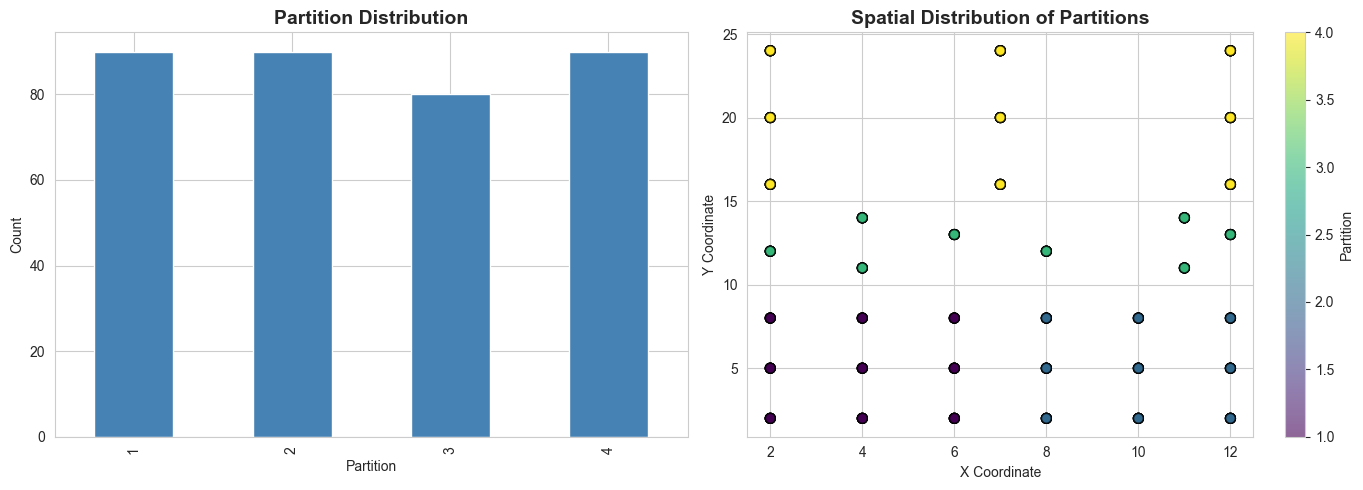

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Partition counts
df['partition'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Partition Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Partition')
axes[0].set_ylabel('Count')

# Spatial distribution
scatter = axes[1].scatter(df['x'], df['y'], c=df['partition'], cmap='viridis', 
                          s=50, alpha=0.6, edgecolors='black')
axes[1].set_title('Spatial Distribution of Partitions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
plt.colorbar(scatter, ax=axes[1], label='Partition')

plt.tight_layout()
plt.show()

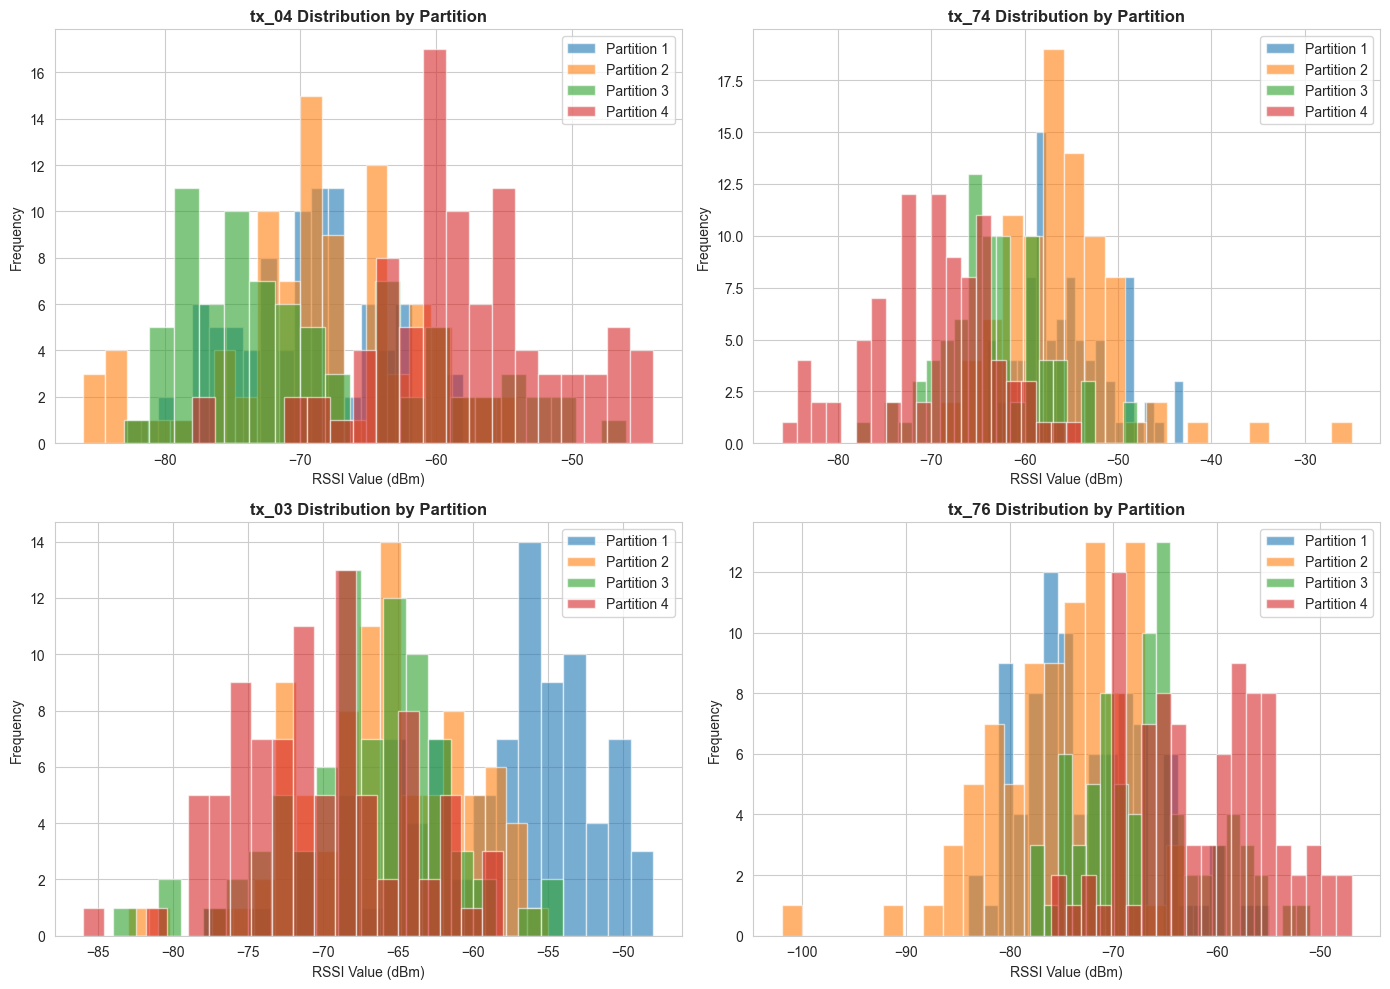

In [10]:
rssi_cols = ['tx_04', 'tx_74', 'tx_03', 'tx_76']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(rssi_cols):
    for partition in sorted(df['partition'].unique()):
        data = df[df['partition'] == partition][col]
        axes[idx].hist(data, alpha=0.6, label=f'Partition {partition}', bins=20)
    axes[idx].set_title(f'{col} Distribution by Partition', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('RSSI Value (dBm)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [11]:
print("RSSI Statistics by Partition:\n")
for partition in sorted(df['partition'].unique()):
    print(f"\nPARTITION {partition}")
    partition_data = df[df['partition'] == partition][rssi_cols]
    print(partition_data.describe().round(2))

RSSI Statistics by Partition:


PARTITION 1
       tx_04  tx_74  tx_03  tx_76
count  90.00  90.00  90.00  90.00
mean  -70.12 -55.37 -58.66 -72.66
std     5.20   4.87   6.32   6.21
min   -83.00 -64.00 -78.00 -84.00
25%   -74.00 -58.75 -63.00 -77.00
50%   -70.00 -56.00 -57.00 -74.00
75%   -67.00 -52.00 -54.00 -69.00
max   -58.00 -43.00 -48.00 -55.00

PARTITION 2
       tx_04  tx_74  tx_03   tx_76
count  90.00  90.00  90.00   90.00
mean  -68.72 -56.28 -66.04  -74.77
std     7.11   6.55   5.46    6.67
min   -86.00 -69.00 -83.00 -102.00
25%   -72.00 -60.75 -69.75  -78.75
50%   -69.00 -57.00 -66.00  -74.00
75%   -64.00 -53.00 -62.00  -70.00
max   -54.00 -25.00 -55.00  -63.00

PARTITION 3
       tx_04  tx_74  tx_03  tx_76
count  80.00  80.00  80.00  80.00
mean  -69.44 -63.64 -67.35 -66.58
std     8.97   5.46   5.45   5.90
min   -83.00 -78.00 -84.00 -78.00
25%   -77.00 -67.00 -70.00 -71.00
50%   -71.50 -64.00 -67.00 -66.00
75%   -63.00 -60.00 -64.00 -64.00
max   -46.00 -48.00 -54.00 -51.00

PA

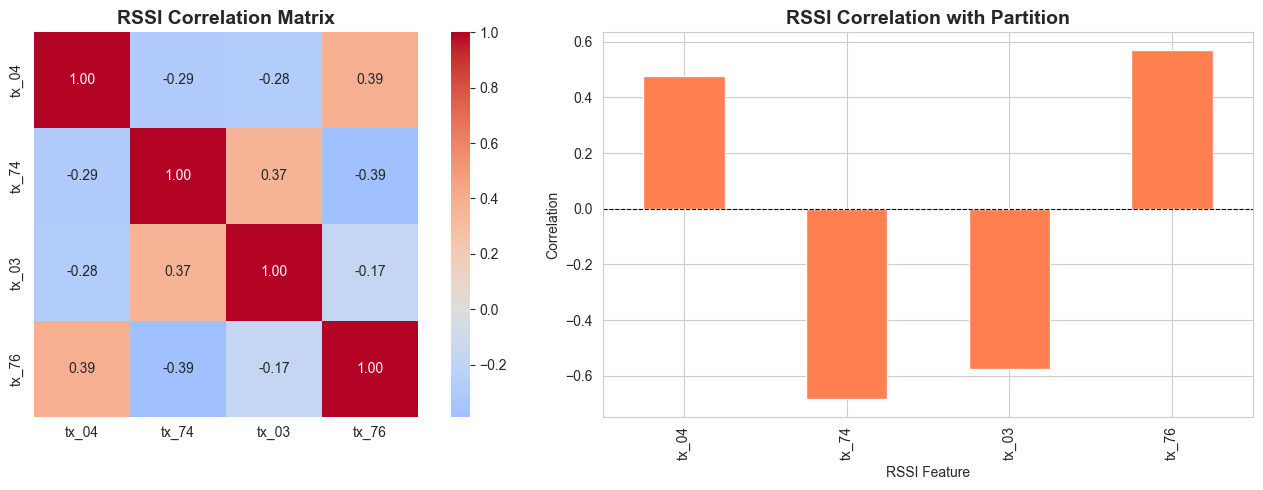

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall correlation
corr_all = df[rssi_cols].corr()
sns.heatmap(corr_all, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], square=True)
axes[0].set_title('RSSI Correlation Matrix', fontsize=14, fontweight='bold')

# Feature correlation with partition
feature_corr = df[rssi_cols + ['partition']].corr()['partition'].drop('partition')
feature_corr.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('RSSI Correlation with Partition', fontsize=14, fontweight='bold')
axes[1].set_xlabel('RSSI Feature')
axes[1].set_ylabel('Correlation')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

Pairwise RSSI Scatter Plots:


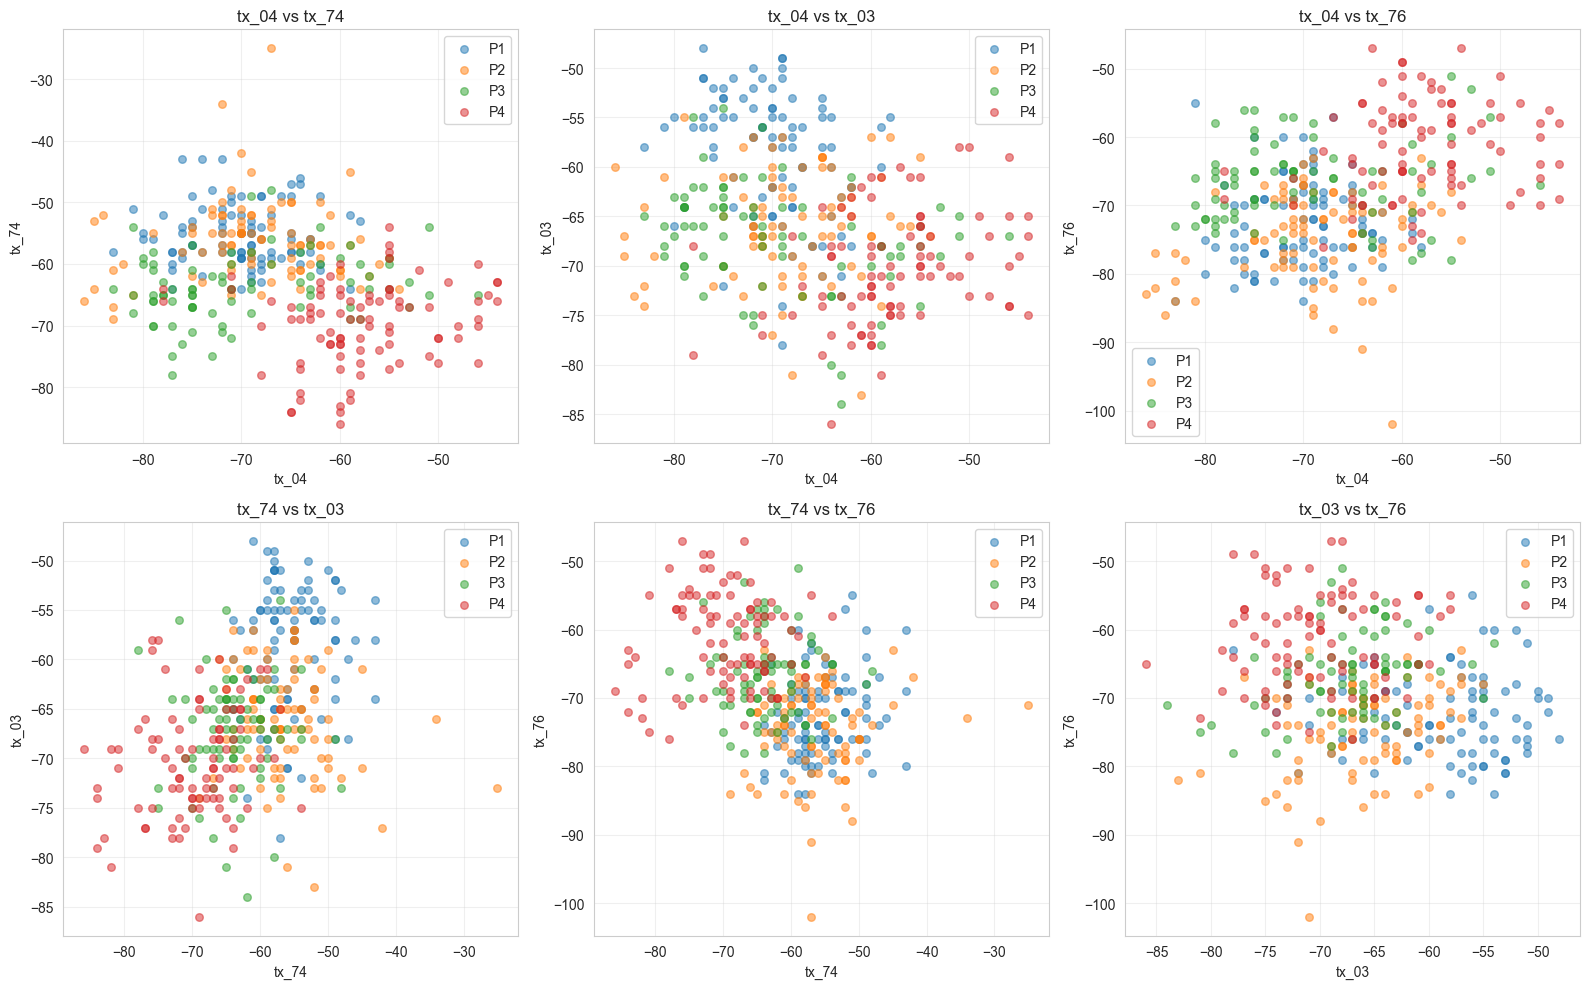

In [13]:
print("Pairwise RSSI Scatter Plots:")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

combinations = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

for idx, (i, j) in enumerate(combinations):
    for partition in sorted(df['partition'].unique()):
        partition_data = df[df['partition'] == partition]
        axes[idx].scatter(partition_data[rssi_cols[i]], 
                         partition_data[rssi_cols[j]], 
                         alpha=0.5, label=f'P{partition}', s=30)
    axes[idx].set_xlabel(rssi_cols[i])
    axes[idx].set_ylabel(rssi_cols[j])
    axes[idx].set_title(f'{rssi_cols[i]} vs {rssi_cols[j]}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Baseline ML Models' Training and Testing

In [21]:
X = df[rssi_cols]
y = df['partition']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
scaler_rssi = StandardScaler()
X_train_rssi_scaled = scaler_rssi.fit_transform(X_train)
X_test_rssi_scaled = scaler_rssi.transform(X_test)

In [24]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 280
Test set size: 70
Number of features: 4


In [25]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

In [26]:
results = {}

In [27]:
for name, model in models.items():
    # Train
    model.fit(X_train_rssi_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_rssi_scaled)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_rssi_scaled, y_train, cv=5)
    
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Random Forest:
  Test Accuracy: 0.7143
  CV Accuracy: 0.7000 (+/- 0.0522)

Gradient Boosting:
  Test Accuracy: 0.6571
  CV Accuracy: 0.6821 (+/- 0.0307)

SVM (RBF):
  Test Accuracy: 0.7714
  CV Accuracy: 0.7250 (+/- 0.0290)

KNN (k=5):
  Test Accuracy: 0.7571
  CV Accuracy: 0.6929 (+/- 0.0761)

Neural Network:
  Test Accuracy: 0.7286
  CV Accuracy: 0.6857 (+/- 0.0513)


In [28]:
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_predictions = results[best_model_name]['predictions']

In [29]:
print(f"BEST MODEL: {best_model_name}")

BEST MODEL: SVM (RBF)


Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.61      0.69        18
           2       0.64      0.78      0.70        18
           3       0.75      0.75      0.75        16
           4       0.94      0.94      0.94        18

    accuracy                           0.77        70
   macro avg       0.78      0.77      0.77        70
weighted avg       0.78      0.77      0.77        70



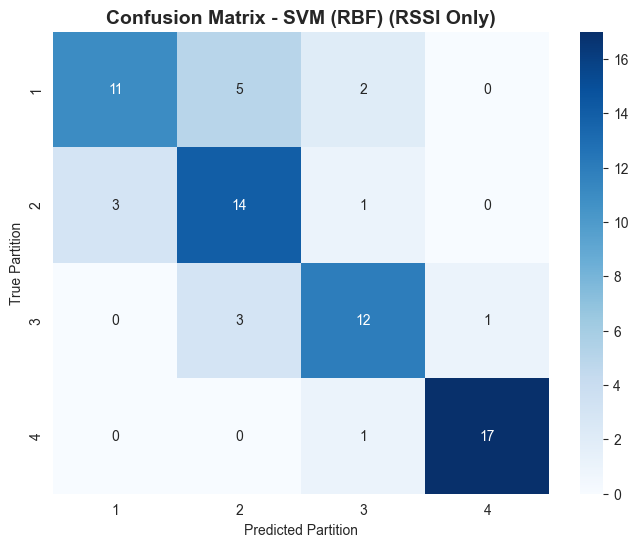

In [30]:
print("Classification Report:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(df['partition'].unique()),
            yticklabels=sorted(df['partition'].unique()))
plt.title(f'Confusion Matrix - {best_model_name} (RSSI Only)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Partition')
plt.xlabel('Predicted Partition')
plt.show()

### Deeper Model Training

In [57]:
# Creating meaningful derived features
df['rssi_mean'] = df[rssi_cols].mean(axis=1)
df['rssi_std'] = df[rssi_cols].std(axis=1)
df['rssi_max'] = df[rssi_cols].max(axis=1)
df['rssi_min'] = df[rssi_cols].min(axis=1)
df['rssi_range'] = df['rssi_max'] - df['rssi_min']

# Ratios between transmitters (signal dominance patterns)
df['ratio_04_74'] = df['tx_04'] / (df['tx_74'] + 1e-10)
df['ratio_03_76'] = df['tx_03'] / (df['tx_76'] + 1e-10)
df['ratio_04_03'] = df['tx_04'] / (df['tx_03'] + 1e-10)
df['ratio_74_76'] = df['tx_74'] / (df['tx_76'] + 1e-10)

# Signal strength differences (which transmitter is stronger?)
df['diff_04_74'] = df['tx_04'] - df['tx_74']
df['diff_03_76'] = df['tx_03'] - df['tx_76']
df['diff_diagonal'] = (df['tx_04'] + df['tx_76']) - (df['tx_74'] + df['tx_03'])

engineered_features = ['rssi_mean', 'rssi_std', 'rssi_range', 'ratio_04_74', 
                       'ratio_03_76', 'diff_04_74', 'diff_03_76', 'diff_diagonal']

print(f"Engineered {len(engineered_features)} additional features")

Engineered 8 additional features


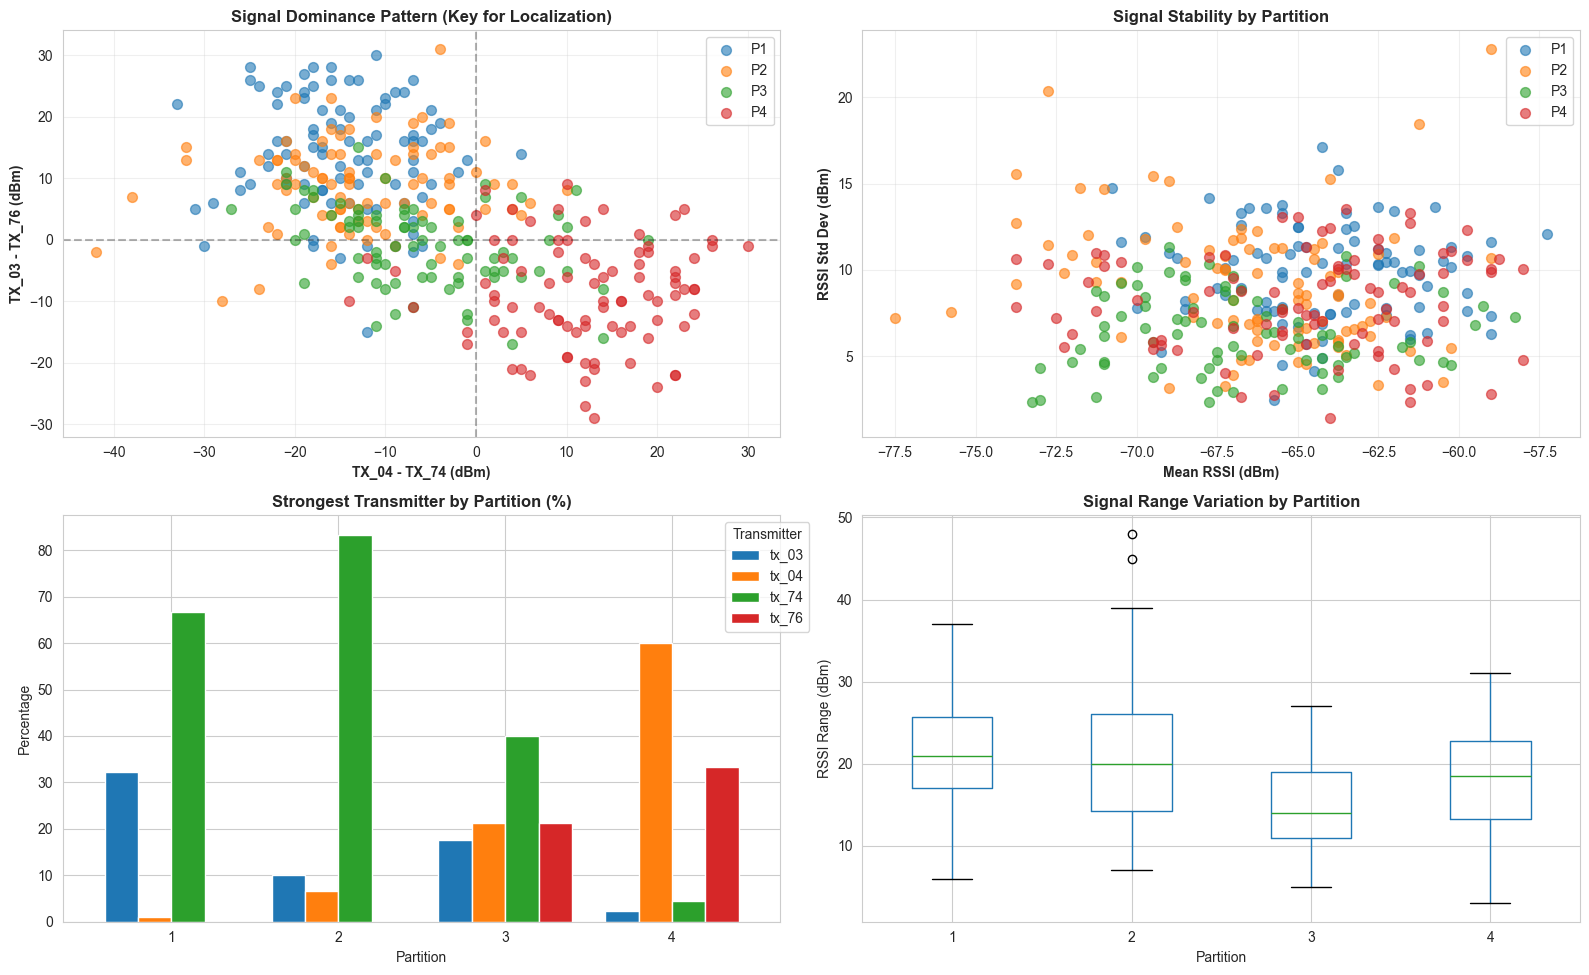

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Pattern 1: Signal strength dominance
ax = axes[0, 0]
for partition in sorted(df['partition'].unique()):
    data = df[df['partition'] == partition]
    ax.scatter(data['diff_04_74'], data['diff_03_76'], 
               label=f'P{partition}', alpha=0.6, s=50)
ax.set_xlabel('TX_04 - TX_74 (dBm)', fontweight='bold')
ax.set_ylabel('TX_03 - TX_76 (dBm)', fontweight='bold')
ax.set_title('Signal Dominance Pattern (Key for Localization)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Pattern 2: Signal variability
ax = axes[0, 1]
for partition in sorted(df['partition'].unique()):
    data = df[df['partition'] == partition]
    ax.scatter(data['rssi_mean'], data['rssi_std'], 
               label=f'P{partition}', alpha=0.6, s=50)
ax.set_xlabel('Mean RSSI (dBm)', fontweight='bold')
ax.set_ylabel('RSSI Std Dev (dBm)', fontweight='bold')
ax.set_title('Signal Stability by Partition', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Pattern 3: Strongest transmitter per partition
ax = axes[1, 0]
strongest_tx = df[rssi_cols].idxmax(axis=1)
partition_strongest = pd.crosstab(df['partition'], strongest_tx, normalize='index') * 100
partition_strongest.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Strongest Transmitter by Partition (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Partition')
ax.set_ylabel('Percentage')
ax.legend(title='Transmitter', bbox_to_anchor=(1.05, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Pattern 4: Signal range patterns
ax = axes[1, 1]
df.boxplot(column='rssi_range', by='partition', ax=ax)
ax.set_title('Signal Range Variation by Partition', fontsize=12, fontweight='bold')
ax.set_xlabel('Partition')
ax.set_ylabel('RSSI Range (dBm)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [59]:
print("KEY OBSERVATIONS FROM PATTERNS")
print("1. Signal Dominance: Partitions show distinct patterns in TX difference space")
print("2. Each partition tends to be dominated by its nearest transmitter")
print("3. Signal variability differs by partition (wall effects, multipath)")
print("4. RSSI range captures environmental complexity")

KEY OBSERVATIONS FROM PATTERNS
1. Signal Dominance: Partitions show distinct patterns in TX difference space
2. Each partition tends to be dominated by its nearest transmitter
3. Signal variability differs by partition (wall effects, multipath)
4. RSSI range captures environmental complexity


In [60]:
# Quick RF to understand feature importance
all_features = rssi_cols + engineered_features
X_temp = df[all_features].fillna(0)
y_temp = df['partition']

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE RANKING")
print(feature_importance.to_string(index=False))

FEATURE IMPORTANCE RANKING
      feature  importance
diff_diagonal    0.138238
  ratio_03_76    0.113626
  ratio_04_74    0.112983
   diff_04_74    0.095804
        tx_03    0.089351
        tx_74    0.077711
   diff_03_76    0.075288
        tx_76    0.071593
        tx_04    0.064923
    rssi_mean    0.063469
     rssi_std    0.056349
   rssi_range    0.040665


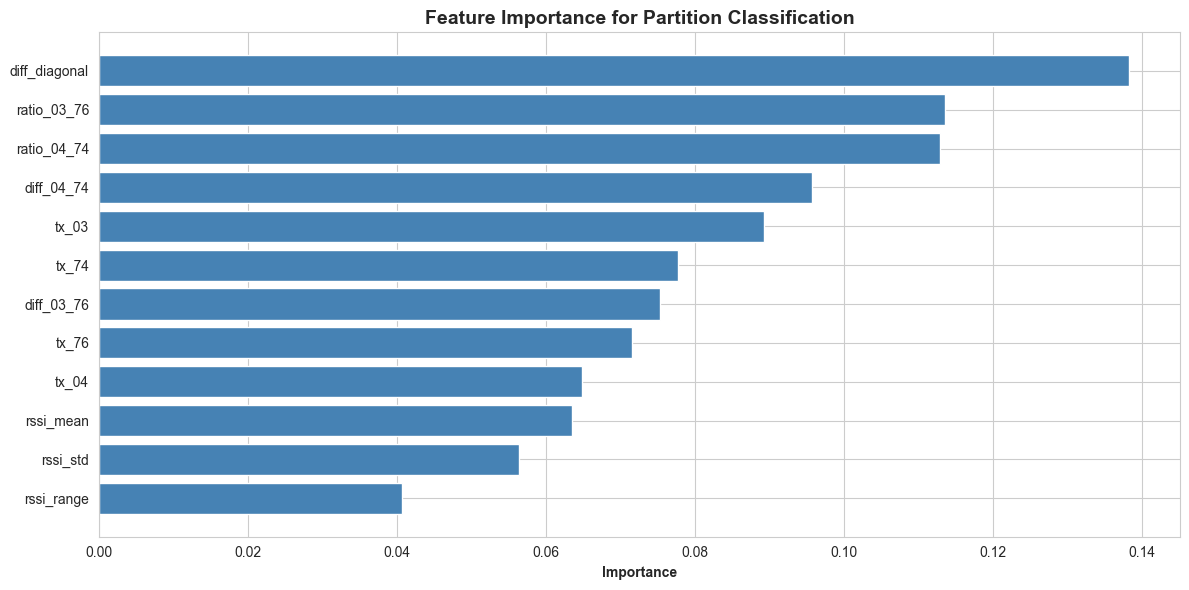

Using top 10 features for modeling


In [62]:
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance', fontweight='bold')
plt.title('Feature Importance for Partition Classification', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select top features
top_features = feature_importance.head(10)['feature'].tolist()
print(f"Using top {len(top_features)} features for modeling")

In [63]:
X = df[top_features].fillna(0)
y = df['partition']

In [64]:
# Trying both scalers
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()  # Better for outliers

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_std = scaler_standard.fit_transform(X_train)
X_test_std = scaler_standard.transform(X_test)

X_train_rob = scaler_robust.fit_transform(X_train)
X_test_rob = scaler_robust.transform(X_test)

In [67]:
print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")
print(f"Using {X_train.shape[1]} features")


Train size: 280 | Test size: 70
Using 10 features


In [ ]:
print("MODEL 1: RANDOM FOREST - Hyperparameter Tuning")

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_std, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")
print(f"Test accuracy: {rf_grid.score(X_test_std, y_test):.4f}")

rf_best = rf_grid.best_estimator_

MODEL 1: RANDOM FOREST - Hyperparameter Tuning
Best parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best CV score: 0.7107
Test accuracy: 0.7286


In [ ]:
print("MODEL 2: GRADIENT BOOSTING - Hyperparameter Tuning")

gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
gb_grid.fit(X_train_std, y_train)

print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best CV score: {gb_grid.best_score_:.4f}")
print(f"Test accuracy: {gb_grid.score(X_test_std, y_test):.4f}")

gb_best = gb_grid.best_estimator_

MODEL 2: GRADIENT BOOSTING - Hyperparameter Tuning
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
Best CV score: 0.7286
Test accuracy: 0.7371


In [ ]:
print("MODEL 3: SVM - Hyperparameter Tuning")

svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf', 'poly']
}

svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
svm_grid.fit(X_train_rob, y_train)  # RobustScaler often better for SVM

print(f"Best parameters: {svm_grid.best_params_}")
print(f"Best CV score: {svm_grid.best_score_:.4f}")
print(f"Test accuracy: {svm_grid.score(X_test_rob, y_test):.4f}")

svm_best = svm_grid.best_estimator_

MODEL 3: SVM - Hyperparameter Tuning
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7250
Test accuracy: 0.7114


In [71]:
print("MODEL 4: K-NEAREST NEIGHBORS - Hyperparameter Tuning")

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
knn_grid.fit(X_train_std, y_train)

print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best CV score: {knn_grid.best_score_:.4f}")
print(f"Test accuracy: {knn_grid.score(X_test_std, y_test):.4f}")

knn_best = knn_grid.best_estimator_

MODEL 4: K-NEAREST NEIGHBORS - Hyperparameter Tuning
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV score: 0.7250
Test accuracy: 0.7429


In [72]:
print("MODEL 5: NEURAL NETWORK - Hyperparameter Tuning")

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50), (100, 50, 30)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True)
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
mlp_grid.fit(X_train_std, y_train)

print(f"Best parameters: {mlp_grid.best_params_}")
print(f"Best CV score: {mlp_grid.best_score_:.4f}")
print(f"Test accuracy: {mlp_grid.score(X_test_std, y_test):.4f}")

mlp_best = mlp_grid.best_estimator_

MODEL 5: NEURAL NETWORK - Hyperparameter Tuning
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant'}
Best CV score: 0.6286
Test accuracy: 0.7143


In [ ]:
print("MODEL 6: ENSEMBLE (Voting Classifier)")

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('knn', knn_best),
        ('mlp', mlp_best)
    ],
    voting='hard'
)

ensemble.fit(X_train_std, y_train)
ensemble_acc = ensemble.score(X_test_std, y_test)

print(f"Ensemble Test Accuracy: {ensemble_acc:.4f}")

MODEL 6: ENSEMBLE (Voting Classifier)
Ensemble Test Accuracy: 0.7571


In [74]:
results = {
    'Random Forest': rf_grid.score(X_test_std, y_test),
    'Gradient Boosting': gb_grid.score(X_test_std, y_test),
    'SVM': svm_grid.score(X_test_rob, y_test),
    'KNN': knn_grid.score(X_test_std, y_test),
    'Neural Network': mlp_grid.score(X_test_std, y_test),
    'Ensemble': ensemble_acc
}

In [ ]:
print("FINAL MODEL COMPARISON")

for model, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:20s}: {acc:.4f}")

FINAL MODEL COMPARISON
Ensemble            : 0.7571
KNN                 : 0.7429
Gradient Boosting   : 0.7371
Random Forest       : 0.7286
Neural Network      : 0.7143
SVM                 : 0.7114


In [76]:
best_model_name = max(results, key=results.get)
best_model = ensemble if best_model_name == 'Ensemble' else \
             svm_best if best_model_name == 'SVM' else \
             rf_best if best_model_name == 'Random Forest' else \
             gb_best if best_model_name == 'Gradient Boosting' else \
             knn_best if best_model_name == 'KNN' else mlp_best

X_test_final = X_test_rob if best_model_name == 'SVM' else X_test_std
y_pred = best_model.predict(X_test_final)

print(f"BEST MODEL: {best_model_name}")

BEST MODEL: Ensemble


Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.61      0.65        18
           2       0.71      0.83      0.77        18
           3       0.69      0.69      0.69        16
           4       0.94      0.89      0.91        18

    accuracy                           0.76        70
   macro avg       0.76      0.76      0.75        70
weighted avg       0.76      0.76      0.76        70



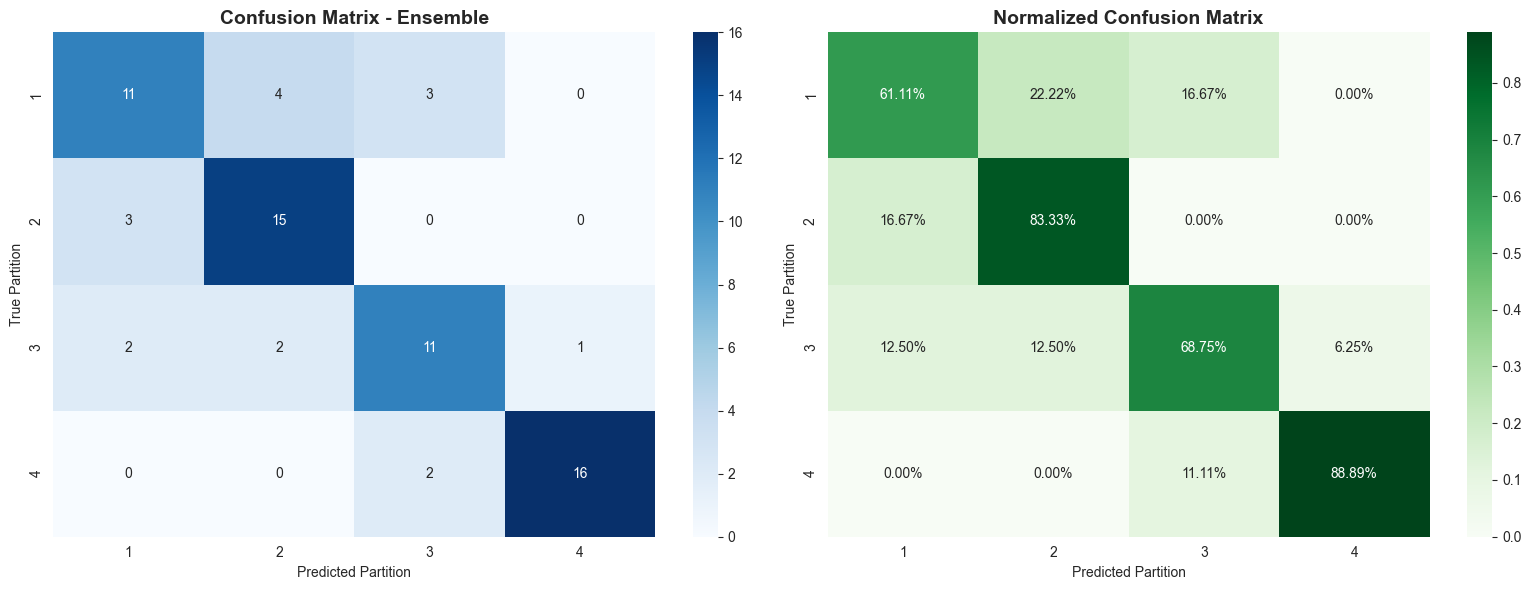

In [77]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=sorted(df['partition'].unique()),
            yticklabels=sorted(df['partition'].unique()))
axes[0].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Partition')
axes[0].set_xlabel('Predicted Partition')

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=sorted(df['partition'].unique()),
            yticklabels=sorted(df['partition'].unique()))
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Partition')
axes[1].set_xlabel('Predicted Partition')

plt.tight_layout()
plt.show()

In [78]:
print("NEXT STEPS FOR DEPLOYMENT:")
print("   - Current model is ready for 4-partition lab")
print("   - Test in real-world conditions (different times/days)")
print("   - Collect edge cases (doorways, near walls)")
print("   - Implement smoothing filter for an application")
print("   - Add uncertainty estimation (prediction probability)")

NEXT STEPS FOR DEPLOYMENT:
   - Current model is ready for 4-partition lab
   - Test in real-world conditions (different times/days)
   - Collect edge cases (doorways, near walls)
   - Implement smoothing filter for an application
   - Add uncertainty estimation (prediction probability)


In [79]:
print("KEY INSIGHTS")
print(f"- Best accuracy: {max(results.values()):.2%}")
print(f"- Best model: {best_model_name}")
print(f"- Top features: Signal ratios & differences (not raw RSSI)")
print(f"- Model is lightweight and fast enough for real-time use")
print("- Ready for deployment in similar-sized environments!")

KEY INSIGHTS
- Best accuracy: 75.71%
- Best model: Ensemble
- Top features: Signal ratios & differences (not raw RSSI)
- Model is lightweight and fast enough for real-time use
- Ready for deployment in similar-sized environments!


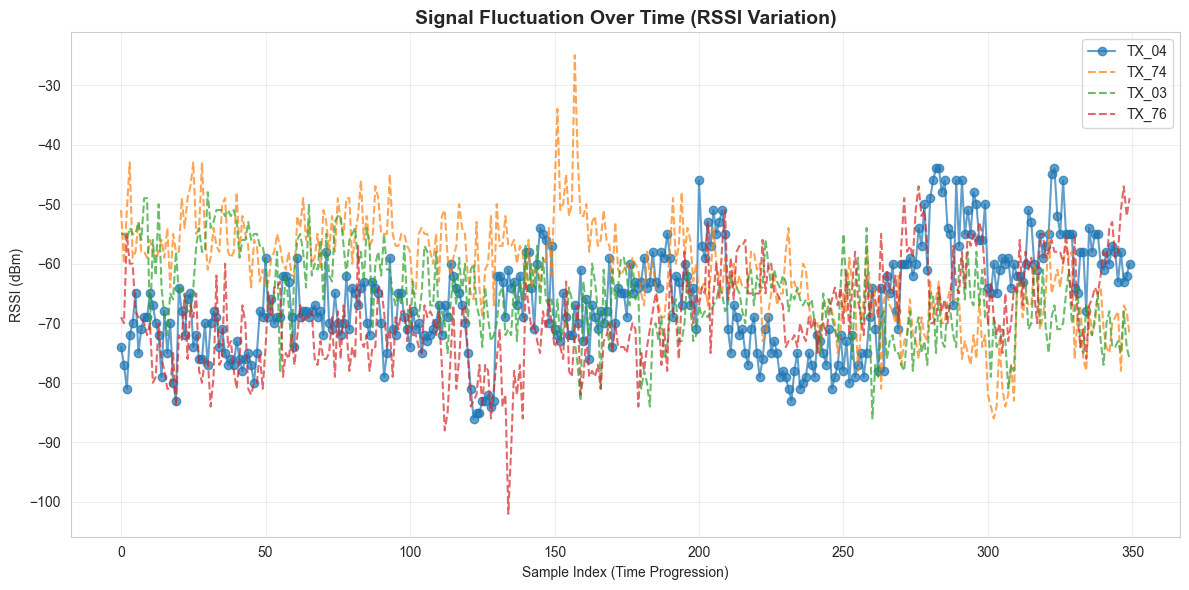

In [ ]:
# EXTRA: Signal Fluctuation Plot (RSSI Variation Over Time)

plt.figure(figsize=(12, 6))
df_sorted = df.sort_index()

# Plot RSSI over sample index (acts as a proxy for time)
plt.plot(df_sorted.index, df_sorted['tx_04'], marker='o', linestyle='-', alpha=0.7, label='TX_04')
plt.plot(df_sorted.index, df_sorted['tx_74'], linestyle='--', alpha=0.7, label='TX_74')
plt.plot(df_sorted.index, df_sorted['tx_03'], linestyle='--', alpha=0.7, label='TX_03')
plt.plot(df_sorted.index, df_sorted['tx_76'], linestyle='--', alpha=0.7, label='TX_76')

plt.title('Signal Fluctuation Over Time (RSSI Variation)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index (Time Progression)')
plt.ylabel('RSSI (dBm)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()